In [1]:
import PIL as PIL
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [2]:
# Read the data
ames = pd.read_csv("C:/Users/ryanc/Desktop/GSB_544/Data/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [3]:
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900


## Pipeline Fitting Ridge Regression with Lambda = 1

In [4]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1) #Drop specific columns that are ID columns, all individual values
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)), #This is being applied to ALL columns with object type, as opposed to specific column
    ("standardize", #Very important to standardize, especially with regards to ridge regression
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough" #I want to keep all my remaining variables, hence passthrough
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [5]:
lr_pipeline_fitted = lr_pipeline_1.fit(X,y)
coef1 = lr_pipeline_fitted.named_steps['linear_regression'].coef_

In [6]:
lr_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 1))])

In [7]:
lr_pipeline_fitted2 = lr_pipeline_2.fit(X,y)
coef2 = lr_pipeline_fitted2.named_steps['ridge_regression'].coef_

In [8]:
comparison = {'Linear': coef1, 'Ridge': coef2}
dataframe = pd.DataFrame(comparison)

### Plot comparing coefficients for Ridge Model and Linear Model

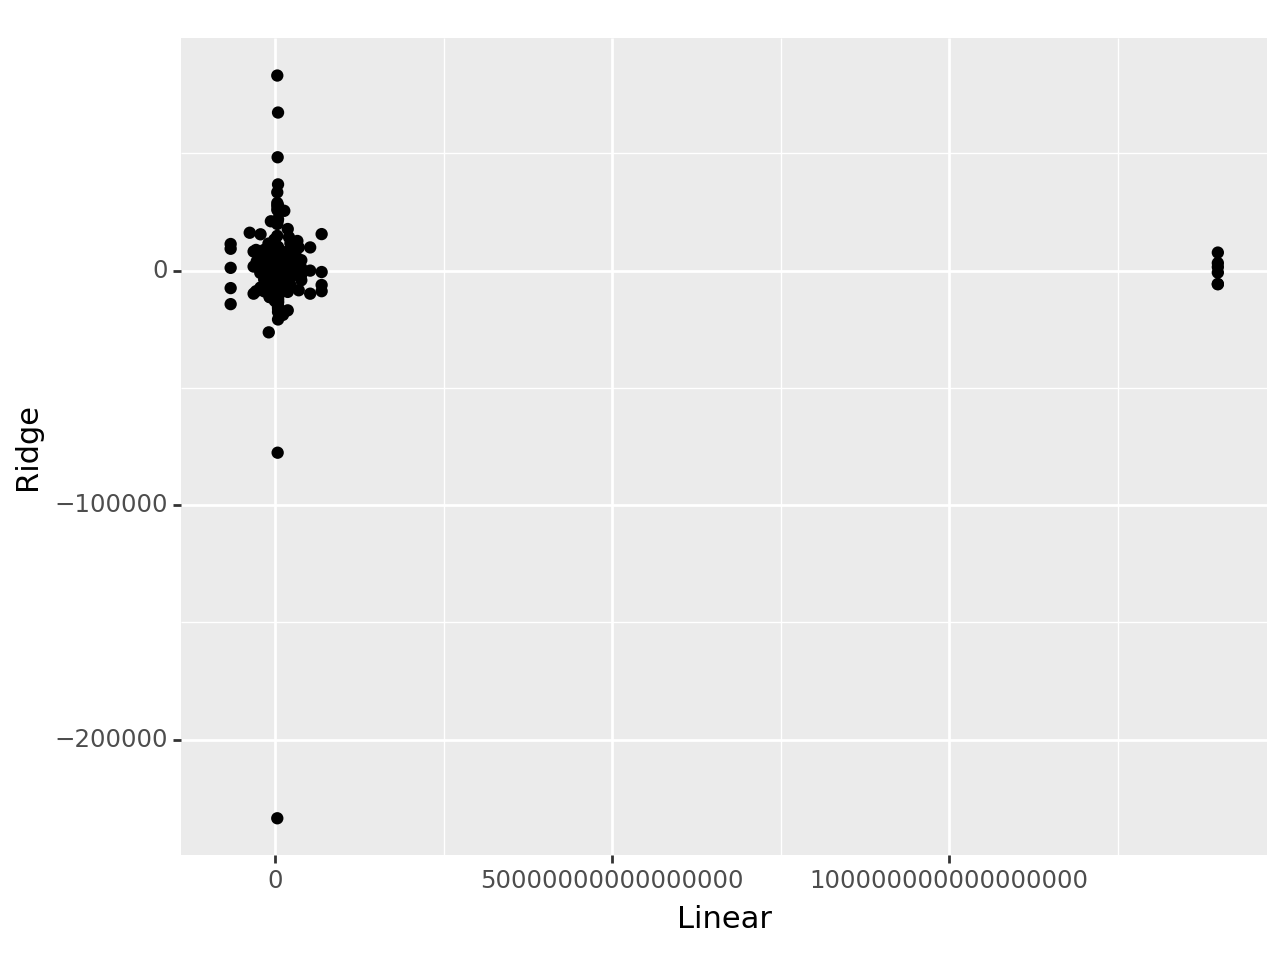

<Figure Size: (640 x 480)>

In [9]:
import plotnine as p9
from plotnine import *
(ggplot(dataframe,
aes(
  x = "Linear",
  y = "Ridge"
))
+ geom_point(
aes()) )

## Tuning on Lambda

In [10]:
result = [.01, .1, 1, 10, 100, 1000]

lambdas = {'ridge_regression__alpha': result}

gscv2 = GridSearchCV(lr_pipeline_2, lambdas, cv = 5, scoring='r2')

In [12]:
gscv_fitted_2 = gscv2.fit(X, y)

gscv_fitted_2.cv_results_

pd.DataFrame(data = {"lambdas": result, "scores": gscv_fitted_2.cv_results_['mean_test_score']})

,lambdas,scores
0,0.01,0.853224
1,0.10,0.855423
2,1.00,0.861159
3,10.00,0.863355
4,100.00,0.857129
5,1000.00,0.832971


### Create a LASSO pipeline, and tune Lambda.

#### Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [15]:
lr_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())])

result = [.01, .1, 1, 10, 100, 1000]

lambdas3 = {'lasso_regression__alpha': result}

gscv3 = GridSearchCV(lr_pipeline_3, lambdas3, cv = 5, scoring='r2')

In [16]:
lr_pipeline_fitted = lr_pipeline_3.fit(X,y)
coef3 = lr_pipeline_fitted.named_steps['lasso_regression'].coef_

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+10, tolerance: 1.793e+09


In [18]:
gscv_fitted_3 = gscv3.fit(X, y)

gscv_fitted_3.cv_results_

pd.DataFrame(data = {"lambdas": result, "scores": gscv_fitted_3.cv_results_['mean_test_score']})

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e+11, tolerance: 1.348e+09
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+11, tolerance: 1.474e+09
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e+11, tolerance: 1.463e+09
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

,lambdas,scores
0,0.01,0.854549
1,0.10,0.855394
2,1.00,0.855890
3,10.00,0.859495
4,100.00,0.866170
5,1000.00,0.839606


In [60]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha = 10))])

ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 10))])

lasso_pipeline_fitted = lasso_pipeline.fit(X,y)
coefL = lasso_pipeline_fitted.named_steps['lasso_regression'].coef_

ridge_pipeline_fitted = ridge_pipeline.fit(X,y)
coefR = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_

In [61]:
comparison = {'Ridge': coefR, 'Lasso': coefL}
dataframe2 = pd.DataFrame(comparison)

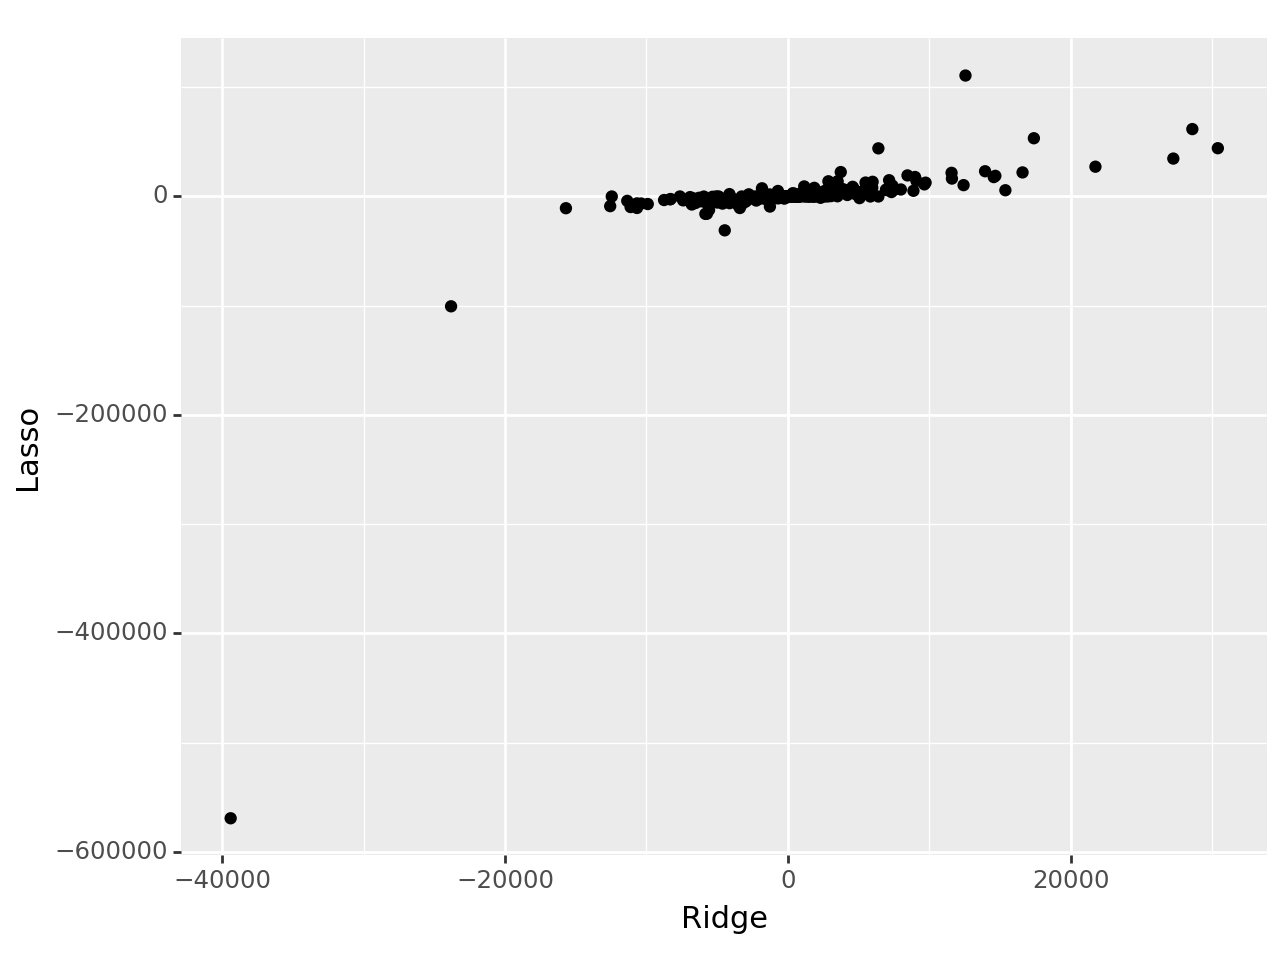

<Figure Size: (640 x 480)>

In [62]:
import plotnine as p9
from plotnine import *
(ggplot(dataframe2,
aes(
  x = "Ridge",
  y = "Lasso"
))
+ geom_point(
aes()))

In [63]:
comparison = {'Linear': coef1, 'Lasso': coefL}
dataframe3 = pd.DataFrame(comparison)

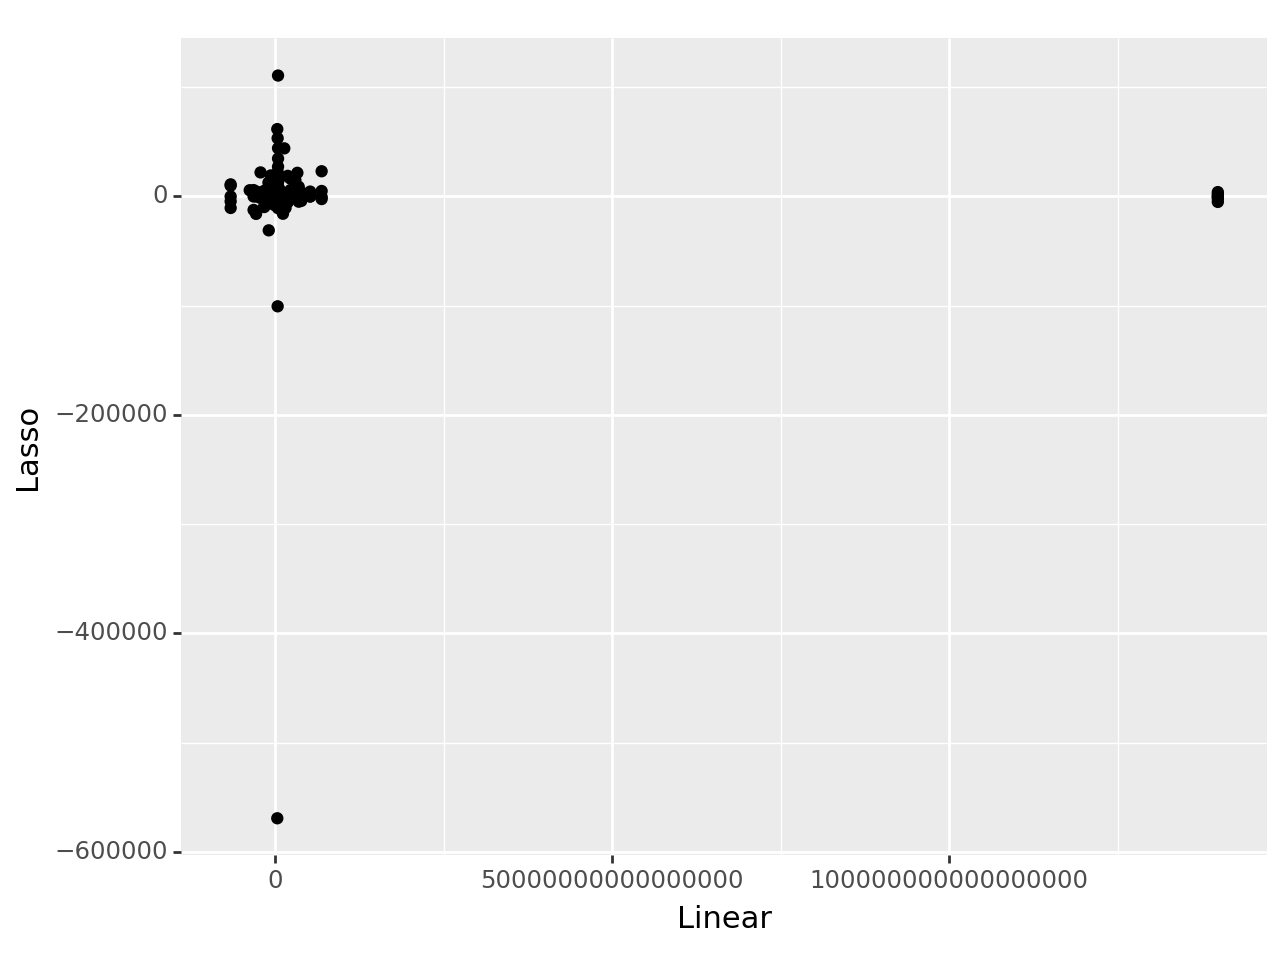

<Figure Size: (640 x 480)>

In [64]:
(ggplot(dataframe3,
aes(
  x = "Linear",
  y = "Lasso"
))
+ geom_point(
aes()))

### Elastic Net pipeline

In [50]:
elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_regression", ElasticNet())])

# Parameter grid for tuning
param_grid_elastic = {
    'elastic_regression__alpha': [0.01, 0.1, 1, 10, 100, 1000],  # Vary these values as needed
    'elastic_regression__l1_ratio': [0.2, 0.4, 0.6, 0.8]  # Vary these values as needed
}

# Grid search with cross-validation for Elastic Net
grid_search_elastic = GridSearchCV(elastic_pipeline, param_grid_elastic, cv=5)

# Fit the Elastic Net pipeline with GridSearchCV
grid_search_elastic.fit(X, y)  # Assuming X and y are your data and target variables

means = grid_search_elastic.cv_results_['mean_test_score']
params = grid_search_elastic.cv_results_['params']

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.902e+11, tolerance: 1.348e+09
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.235e+11, tolerance: 1.474e+09
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.815e+11, tolerance: 1.463e+09
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

In [51]:
means

array([0.86304937, 0.86327863, 0.86335021, 0.86303511, 0.85311294,
       0.85519428, 0.8577219 , 0.86093929, 0.81911201, 0.8266542 ,
       0.83479725, 0.8445356 , 0.58657334, 0.64281506, 0.706791  ,
       0.77632294, 0.12482114, 0.1620953 , 0.22783782, 0.3734595 ,
       0.00532272, 0.01012102, 0.01958429, 0.04693887])

In [52]:
params

[{'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.2},
 {'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.4},
 {'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.6},
 {'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.8},
 {'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.2},
 {'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.4},
 {'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.6},
 {'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.8},
 {'elastic_regression__alpha': 1, 'elastic_regression__l1_ratio': 0.2},
 {'elastic_regression__alpha': 1, 'elastic_regression__l1_ratio': 0.4},
 {'elastic_regression__alpha': 1, 'elastic_regression__l1_ratio': 0.6},
 {'elastic_regression__alpha': 1, 'elastic_regression__l1_ratio': 0.8},
 {'elastic_regression__alpha': 10, 'elastic_regression__l1_ratio': 0.2},
 {'elastic_regression__alpha': 10, 'elastic

### Table with most ideal combination of Lambda and Alpha values

In [53]:
elastic = pd.DataFrame(data = {"parameters": params, "scores": means})

elastic_sorted = elastic.sort_values(by='scores', ascending=False)

pd.set_option('display.max_colwidth', None)

elastic_sorted

,parameters,scores
2,"{'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.6}",0.863350
1,"{'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.4}",0.863279
0,"{'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.2}",0.863049
3,"{'elastic_regression__alpha': 0.01, 'elastic_regression__l1_ratio': 0.8}",0.863035
7,"{'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.8}",0.860939
6,"{'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.6}",0.857722
5,"{'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.4}",0.855194
4,"{'elastic_regression__alpha': 0.1, 'elastic_regression__l1_ratio': 0.2}",0.853113
11,"{'elastic_regression__alpha': 1, 'elastic_regression__l1_ratio': 0.8}",0.844536
10,"{'elastic_regression__alpha': 1, 'elastic_regression__l1_ratio': 0.6}",0.834797


In [55]:
fit_elastic_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_regression", ElasticNet(l1_ratio = .6, alpha = .01))])

In [56]:
fit_elastic_pipeline_fitted = fit_elastic_pipeline.fit(X,y)
coefE = fit_elastic_pipeline_fitted.named_steps['elastic_regression'].coef_

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.693e+11, tolerance: 1.793e+09


## Comparison of Lasso vs Elastic Coeff

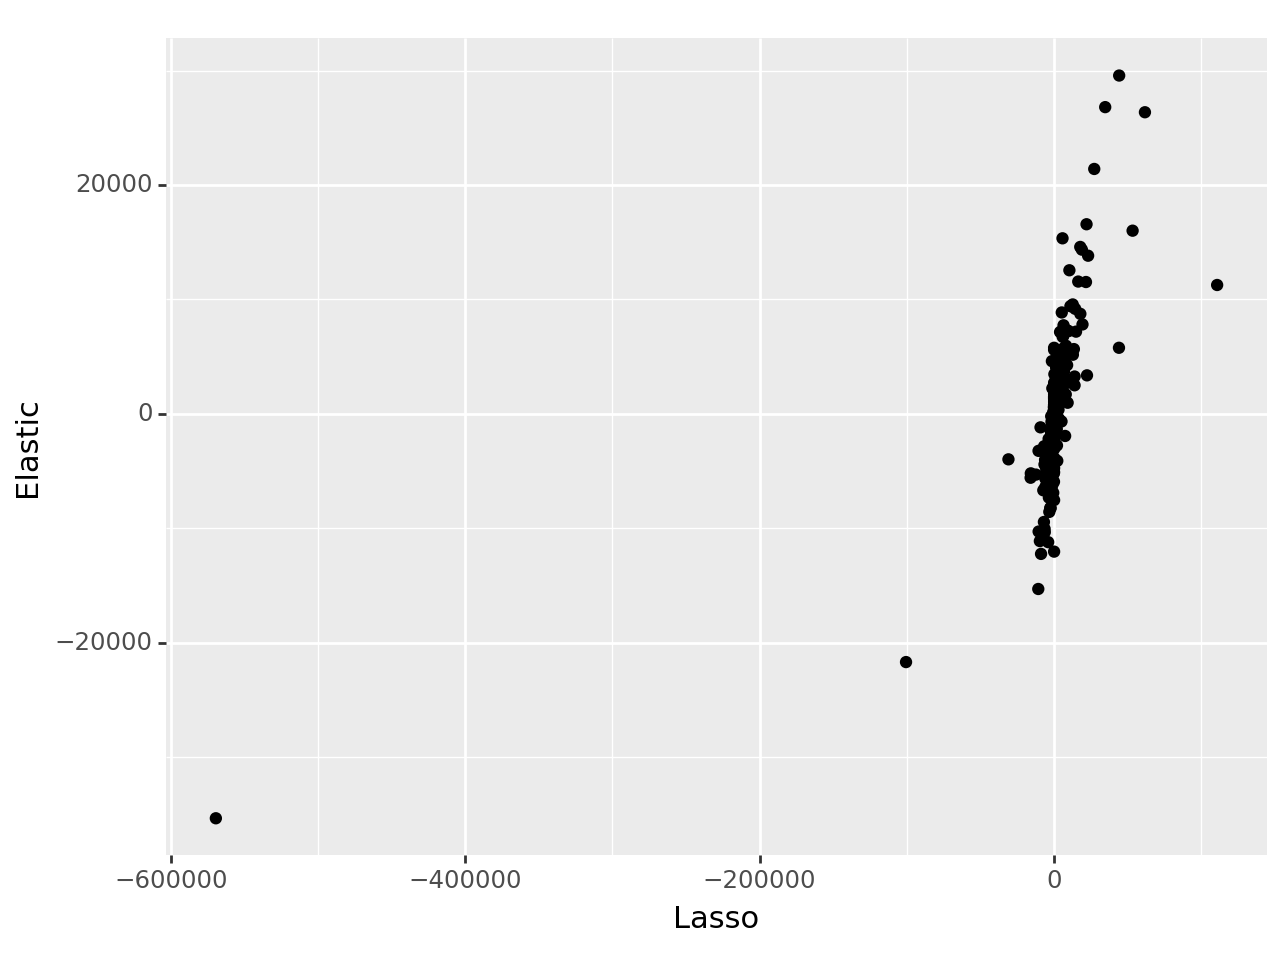

<Figure Size: (640 x 480)>

In [65]:
comparisonLasso = {'Lasso': coefL, 'Elastic': coefE}
dataframeLasso = pd.DataFrame(comparisonLasso)

(ggplot(dataframeLasso,
aes(
  x = "Lasso",
  y = "Elastic"
))
+ geom_point(
aes()))

## Comparison of Ridge vs Elastic Coeff

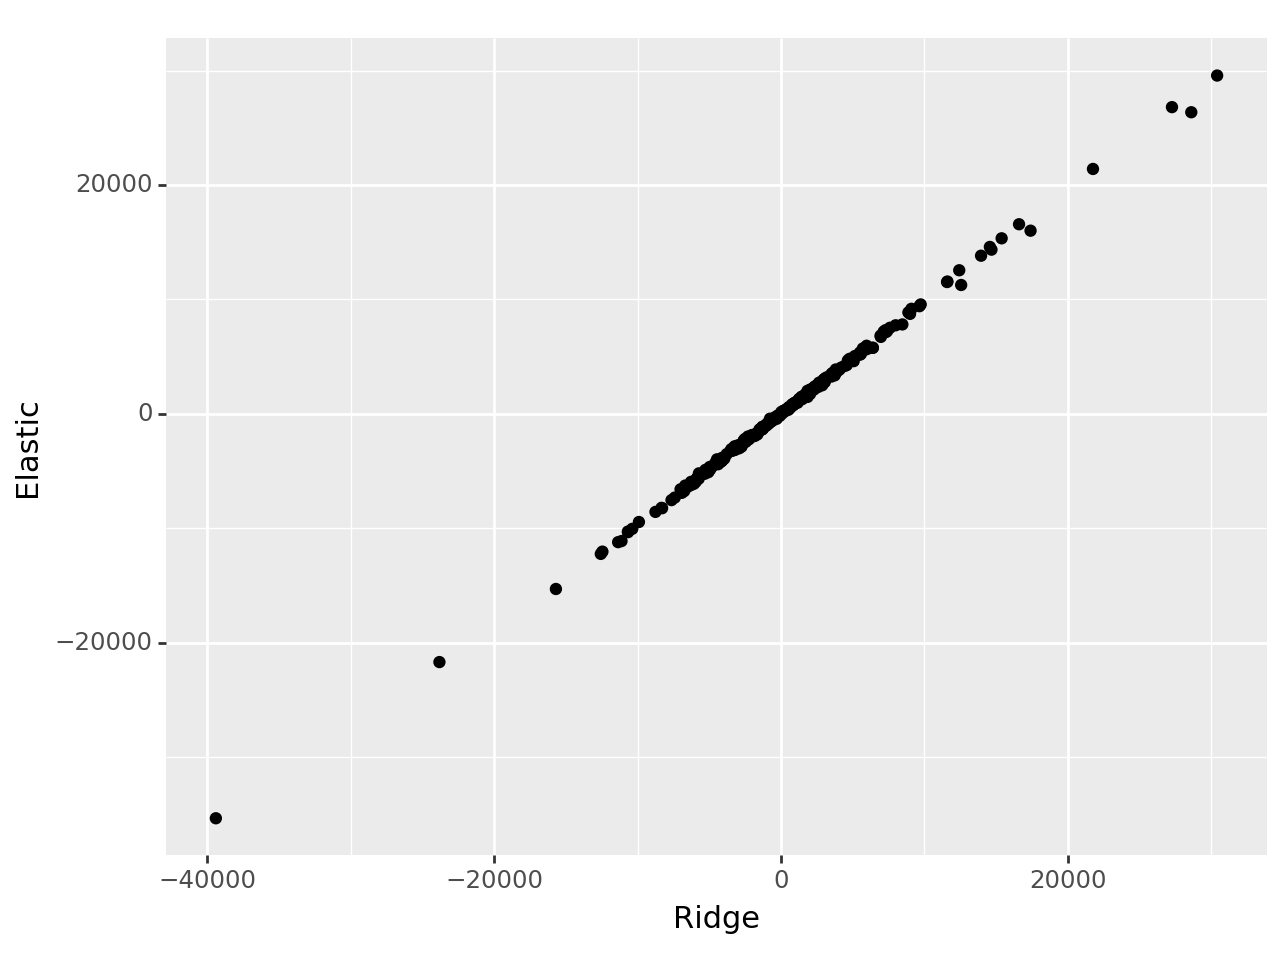

<Figure Size: (640 x 480)>

In [67]:
comparisonRidge = {'Ridge': coefR, 'Elastic': coefE}
dataframeRidge = pd.DataFrame(comparisonRidge)

(ggplot(dataframeRidge,
aes(
  x = "Ridge",
  y = "Elastic"
))
+ geom_point(
aes()))